# Dataset Parsing about Pascal VOC Format

In [69]:
import os
import xml.etree.ElementTree as ET
import xmltodict

from tqdm.notebook import tqdm


In [60]:
ROOT_DIR = os.path.abspath("../")
DATA_DIR = os.path.abspath("../../data/PascalVOC")

# years = ['2010', '2012']
# data_paths = [os.path.join(DATA_DIR,'VOCdevkit/VOC{}'.format(year)) for year in years]
data_path = os.path.join(DATA_DIR,'VOCdevkit/VOC{}'.format(years[1]))

In [61]:
ann_path = os.path.join(data_path, 'Annotations')
img_path = os.path.join(data_path, 'JPEGImages')

# Data type별 분리(train, trainval, val, test)
train_imgset = os.path.join(data_path, 'ImageSets', 'Main', 'train.txt')
trainval_imgset = os.path.join(data_path, 'ImageSets', 'Main', 'trainval.txt')
val_imgset = os.path.join(data_path, 'ImageSets', 'Main', 'val.txt')
# test_imgset = os.path.join(data_path, 'ImageSets', 'Main', 'test.txt')

In [92]:
def imgset_file_read(path):
    arr = []
    with open(path) as f:
        for line in f:
            arr.append(line.strip() + '.jpg')
    return arr

img_files = dict()
img_files['train'] = imgset_file_read(train_imgset)
img_files['trainval'] = imgset_file_read(trainval_imgset)
img_files['val'] = imgset_file_read(val_imgset)
# img_files['test'] = imgset_file_read(test_imgset)

for key in img_files.keys():
    print('number of {} image :: {}'.format(key, len(img_files[key])))

number of train image :: 5717
number of trainval image :: 11540
number of val image :: 5823


In [143]:
ann_files = [os.path.join(ann_path, ann) for ann in os.listdir(ann_path)]
ann_files = tqdm(ann_files)
imgsets = ['trainval', 'train', 'val']

all_ann_data = []

for idx, ann in enumerate(ann_files):
    ann_files.set_description("Processing :: {}".format(ann.split(os.sep)[-1]))
    
    with open(ann) as f:
        doc = xmltodict.parse(f.read())
    
    element = doc['annotation']
    objects = element['object'] if isinstance(element['object'], list) else [element['object']]
    filename = element['filename']
    width = element['size']['width']
    height = element['size']['height']

    annotation_data = dict()
    annotation_data['filepath'] = os.path.join(img_path, filename)
    annotation_data['width'] = width
    annotation_data['height'] = height
    annotation_data['bboxes'] = []
    annotation_data['image_id'] = idx

    if filename in img_files[imgsets[0]]:
        annotation_data['imageset'] = imgsets[0]
    else:
        continue
    
    for obj in objects:
        obj_info = dict()
        obj_info['class'] = obj['name']
        obj_info['x1'] = int(round(float(obj['bndbox']['xmin'])))
        obj_info['y1'] = int(round(float(obj['bndbox']['ymin'])))
        obj_info['x2'] = int(round(float(obj['bndbox']['xmax'])))
        obj_info['y2'] = int(round(float(obj['bndbox']['ymax'])))
        annotation_data['bboxes'].append(obj_info)

    all_ann_data.append(annotation_data)

print(len(all_ann_data))


11540


In [333]:
imgsets = ['trainval', 'train', 'val']

file_list = tqdm(img_files[imgsets[0]][:30])
all_ann_data = []
classes_count = {}
class_mapping = {}

for img_file in file_list:
    file_list.set_description("Processing :: {}".format(img_file))
    
    ann_file = os.path.join(ann_path, '{}.xml'.format(img_file.split('.')[0]))
    
    with open(ann_file) as f:
        doc = xmltodict.parse(f.read())
    
    element = doc['annotation']
    objects = element['object'] if isinstance(element['object'], list) else [element['object']]
    filename = element['filename']
    width = element['size']['width']
    height = element['size']['height']

    annotation_data = dict()
    annotation_data['filepath'] = os.path.join(img_path, filename)
    annotation_data['width'] = width
    annotation_data['height'] = height
    annotation_data['bboxes'] = []
    annotation_data['image_id'] = idx

    if filename in img_files[imgsets[0]]:
        annotation_data['imageset'] = imgsets[0]
    else:
        continue
    
    for obj in objects:
        obj_info = dict()
        
        class_name = obj['name']
        if class_name not in classes_count:
            classes_count[class_name] = 1
        else:
            classes_count[class_name] += 1

        # class mapping 정보 추가
        if class_name not in class_mapping:
            class_mapping[class_name] = len(class_mapping)  # 마지막 번호로 추가
            
        obj_info['class'] = class_name
        obj_info['x1'] = int(round(float(obj['bndbox']['xmin'])))
        obj_info['y1'] = int(round(float(obj['bndbox']['ymin'])))
        obj_info['x2'] = int(round(float(obj['bndbox']['xmax'])))
        obj_info['y2'] = int(round(float(obj['bndbox']['ymax'])))
        annotation_data['bboxes'].append(obj_info)

    all_ann_data.append(annotation_data)

print('\nClasses Count ::', classes_count)
print('\nClasses Number Mapping ::', class_mapping)
print('\nNumber of Annotation ::', len(all_ann_data))



Classes Count :: {'tvmonitor': 3, 'train': 2, 'person': 23, 'boat': 3, 'horse': 1, 'cow': 2, 'bottle': 7, 'dog': 6, 'aeroplane': 3, 'car': 6, 'bus': 1, 'bicycle': 2, 'chair': 11, 'diningtable': 2, 'pottedplant': 2, 'bird': 2, 'cat': 2}

Classes Number Mapping :: {'tvmonitor': 0, 'train': 1, 'person': 2, 'boat': 3, 'horse': 4, 'cow': 5, 'bottle': 6, 'dog': 7, 'aeroplane': 8, 'car': 9, 'bus': 10, 'bicycle': 11, 'chair': 12, 'diningtable': 13, 'pottedplant': 14, 'bird': 15, 'cat': 16}

Number of Annotation :: 30


### Bounding Box Visualize Using OpenCV

10
10
10
10
10


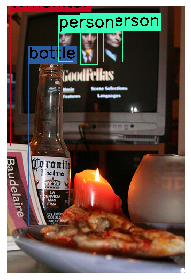

In [334]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

class_to_color = {v: np.random.randint(0, 255, 3) for v in class_mapping}

idx = np.random.randint(0, len(all_ann_data))
ann = all_ann_data[idx]
bboxes = ann['bboxes']
img = cv2.imread(os.path.join(img_path, ann['filepath']))

for bbox in bboxes:
    class_name = bbox['class']
    cv2.rectangle(img, (bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']),
                 (int(class_to_color[class_name][0]), 
                  int(class_to_color[class_name][1]), 
                  int(class_to_color[class_name][2])), 1)
    (retval,baseLine) = cv2.getTextSize(class_name,cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    textOrg = (bbox['x1'], bbox['y1'] - 0)
    print(baseLine)

#     cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, 
                  (textOrg[0], textOrg[1]+baseLine), 
                  (textOrg[0]+retval[0], textOrg[1]-retval[1]), 
                  (int(class_to_color[class_name][0]), 
                  int(class_to_color[class_name][1]), 
                  int(class_to_color[class_name][2])), -1)
    cv2.putText(img, class_name, textOrg, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)


plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.tight_layout()

### Bounding Box Visualize Using Pillow

In [386]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

box_to_color_map = {v: STANDARD_COLORS[class_mapping[v] % len(STANDARD_COLORS)] for v in class_mapping}
box_to_color_map

{'tvmonitor': 'AliceBlue',
 'train': 'Chartreuse',
 'person': 'Aqua',
 'boat': 'Aquamarine',
 'horse': 'Azure',
 'cow': 'Beige',
 'bottle': 'Bisque',
 'dog': 'BlanchedAlmond',
 'aeroplane': 'BlueViolet',
 'car': 'BurlyWood',
 'bus': 'CadetBlue',
 'bicycle': 'AntiqueWhite',
 'chair': 'Chocolate',
 'diningtable': 'Coral',
 'pottedplant': 'CornflowerBlue',
 'bird': 'Cornsilk',
 'cat': 'Crimson'}

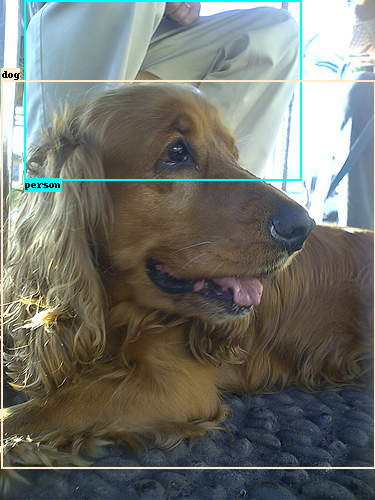

In [425]:
from PIL import Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

class_to_color = {v: np.random.randint(0, 255, 3) for v in class_mapping}

idx = np.random.randint(0, len(all_ann_data))
ann = all_ann_data[idx]
bboxes = ann['bboxes']
img = Image.open(os.path.join(img_path, ann['filepath']))

draw = ImageDraw.Draw(img)

for bbox in bboxes:
    color = box_to_color_map[bbox['class']]
    (left, right, top, bottom) = (bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2'])
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=2, fill=color)

    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()
    
    display_str_list = [bbox['class']]
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), 
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill='black',
                  font=font)
        
        text_bottom -= text_height - 2 * margin

img